In [1]:
%load_ext watermark
%watermark -a "Teresiah Kahura" -d -t -v -p numpy,pandas,matplotlib -g

Teresiah Kahura 2020-08-06 11:35:33 

CPython 3.7.3
IPython 7.16.1

numpy 1.18.5
pandas 0.24.2
matplotlib 3.0.3
Git hash: HEAD


In [2]:
from __future__ import print_function
%matplotlib inline

import datetime

import os

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split

import re
import string

PROJ_ROOT = os.path.join(os.pardir, os.pardir)

In [3]:
unpickled_df = pd.read_pickle("./reviews2.pkl")

In [4]:
len(unpickled_df)

3268

# Preprocessing

In [5]:
x = unpickled_df["text"]
y = unpickled_df["label"]

In [6]:
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation.lower())
    return txt

x = [clean_text(i) for i in x]

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)

In [8]:
def get_sequence_of_tokens(corpus):
    ## tokenization
    
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        input_sequences.append(token_list)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(x)

In [9]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='post'))
   
    predictors = input_sequences[:,:-1]
    return predictors, max_sequence_len

predictors, max_sequence_len = generate_padded_sequences(inp_sequences)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(predictors, y, test_size=0.10, random_state=42)

In [11]:
len(x_train)

2941

In [12]:
x_val = x_train[:300]
partial_xtrain = x_train[300:]

In [13]:
len(y_train)

2941

In [14]:
y_val = y_train[:300]
partial_ytrain = y_train[300:]

In [15]:
print(len(y_test))
print(len(x_test))

327
327


In [16]:
print(len(x_val))
print(len(y_val))

300
300


In [17]:
def build_model():
  opt = Adam(lr=0.01)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(total_words, 128))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.7, recurrent_dropout=0.7, return_sequences=True)))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
  model.add(tf.keras.layers.Dense(6, kernel_regularizer = regularizers.l1_l2(0.3)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

lstm_model = build_model()

In [18]:
!rm -r /tmp/logs/

In [19]:
#creating directory for temp logs (model output logs) so you can viz in tensorboard
#tensorboard_callback: as model is running, what do you want to capture?
#checkpointer: where you save the best model results in each epoch not final model
#logits to validate model in model.compile

logdir = os.path.join("/tmp/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/tmp/sentiment_analysis.hdf5', 
                                                  verbose = 1, 
                                                  save_best_only= True)


In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
history_lstm = lstm_model.fit(x_train, y_train, epochs = 5, batch_size = 128, validation_data = (x_val, y_val),
                              shuffle=False, callbacks = [tb_callback, checkpoint])

Epoch 1/5
 1/23 [>.............................] - ETA: 0s - loss: 24.4799 - accuracy: 0.5000WARNING:tensorflow:From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
23/23 [==============================] - ETA: 0s - loss: 9.5520 - accuracy: 0.6647
Epoch 00001: val_loss improved from inf to 3.06589, saving model to /tmp/sentiment_analysis.hdf5
23/23 [==============================] - 53s 2s/step - loss: 9.5520 - accuracy: 0.6647 - val_loss: 3.0659 - val_accuracy: 0.8067
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 1.8795 - accuracy: 0.7725
Epoch 00002: val_loss improved from 3.06589 to 1.17976, saving model to /tmp/sentiment_analysis.hdf5
23/23 [==============================] - 50s 2s/step - loss: 1.8795 - accuracy: 0.7725 

In [21]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+ metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+ metric])
  plt.show()
    


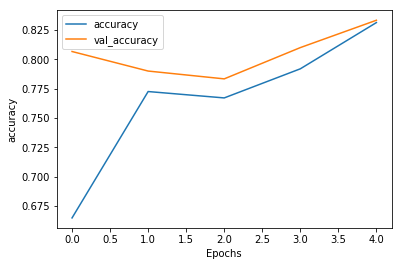

In [22]:
plot_graphs(history_lstm, 'accuracy')

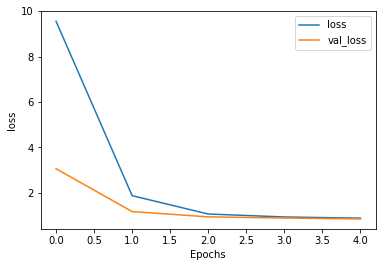

In [23]:
plot_graphs(history_lstm, 'loss')